<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Corrigindo Problemas Comuns do Processo de Validação

### Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#métrica de performance
from sklearn.metrics import roc_auc_score

#modelo a ser treinado
from sklearn.tree import DecisionTreeClassifier

#### Importação da base de dados

In [2]:
df = pd.read_csv('base_rh.csv',sep=";")

## Problema 1) Viés pelo Processo de Validação de Modelos com Testes de Hiperparâmetros

**O que acontece**: Quando usamos a base de testes para comparar o medida de performance com a base de treino, temos que tomar cuidado de não ficar fazendo "tentativa e erro" de hiperparâmetros até encontrar a métrica ideal.

O correto ao se fazer essa abordagem de "busca" do melhor hiperparâmetro é fazer um novo split da base, somente para "validar" o hiperparâmetro correto, e depois testar o modelo na base de teste habitual. 

Ou seja, teríamos a base de:
- **Treino** (para treinar o modelo), 
- **Validação** (para encontrar o melhor hiperparâmetro) e 
- **Teste** (para de fato verificar o quanto seu modelo pode ser generalizado).

#### 1.1) Como fazer?

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Separação das variáveis explicativas e a variável target
x = df.drop('Funcionário_deixou_a_empresa', axis=1)
y = df['Funcionário_deixou_a_empresa']

In [5]:
# Criando as variáveis dummies
x = pd.get_dummies(x)

##### Separação das bases em 70% Treino, 15% Validação e 15% Teste

In [6]:
train_ratio = 0.70
valid_ratio = 0.15
test_ratio = 0.15

In [7]:
# Passo 1) Particionamos a base em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=test_ratio,
                                                    random_state=50)

In [8]:
# Passo 2) Particionamos a base de Treino anterior em 85% para Treino e 15% para Teste
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    train_size=train_ratio/(1-test_ratio),
                                                    random_state=50)

In [9]:
X_train.shape

(1028, 36)

In [10]:
X_valid.shape

(221, 36)

In [11]:
X_test.shape

(221, 36)

### Treinamento de uma Árvore de Decisão usando Scikit Learn

In [15]:
def treina_arvore(max_depth):
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    modelo.fit(X_train, y_train)
    
    # Treino
    prob_train = modelo.predict_proba(X_train)[:,1]
    
    # Validação
    prob_valid = modelo.predict_proba(X_valid)[:,1]
    
    return pd.DataFrame({"max_depth": max_depth, "AUC em Treino:": roc_auc_score(y_train, prob_train), "AUC em Valid:": roc_auc_score(y_valid, prob_valid)},index=[0])

In [16]:
arvores = pd.DataFrame()

for max_depth in range(2,10):
    arvores = pd.concat([arvores,treina_arvore(max_depth)],axis = 0)
    
arvores = arvores.reset_index().drop('index',axis = 1)
arvores

,max_depth,AUC em Treino:,AUC em Valid:
0,2,0.693883,0.700613
1,3,0.743426,0.733957
2,4,0.792951,0.738990
3,5,0.832187,0.738912
4,6,0.870748,0.748113
5,7,0.908057,0.744810
6,8,0.941374,0.669550
7,9,0.959893,0.679774


Após escolhermos o hiperparâmetro ideal (considerando um alto valor em Teste e uma diferença baixa em relação ao AUC de Treino), usamos esse modelo para aplicar testar na base de teste. Veja:

In [17]:
# vamos escolher o modelo de parâmetro max_depth = 3

modelo_final = DecisionTreeClassifier(max_depth=3)
modelo_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [18]:
# Teste
prob_test = modelo_final.predict_proba(X_test)[:,1]
roc_test = roc_auc_score(y_test, prob_test)
print("AUC em Teste:", roc_test)

AUC em Teste: 0.7247816286277825


Portanto, a medida de performance geral do modelo é esse: **AUC = 0,72**. 

## Problema 2) Data Preparation antes do Particionamento

**O que acontece**: Quando realizamos algum tipo de Data Preparation antes de particionamento, acabamos usando informação da base de teste (ou validação) para a base de treino. Desta forma, temos a impressão errada de que o modelo ficou bom em treino e teste, porém de forma artificial.

Alguns tipos de tarefas de Data Prep muito comuns que podem prejudicar seu modelo se realizada antes do particionamento:

- Feature Scalling (Ex: Padronização de variáveis com MinMaxScaler() etc.)
- Feature Selection (Ex: Análise IV com a Base Toda para só depois particionar)
- Imputação de Missing (Ex: Imputar missings com a média da variável inteira)

#### 2.1) Como NÃO fazer?

In [19]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [20]:
X, y = make_classification(n_samples=300, n_features=10, n_informative=8, n_redundant=0, random_state=42)

In [21]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9
0,-0.783721,3.479157,1.442224,-0.352056,1.699368,-2.401386,-0.105827,1.464040,0.016549,0.893110
1,0.629242,2.400704,1.573403,-1.345832,0.505253,0.602051,-0.872025,1.001599,-0.540253,0.508362
2,0.791426,-0.958609,3.018124,-0.633945,-0.402361,-2.277225,1.196483,-0.881467,-0.651064,-1.587332
3,-2.154121,1.181557,0.432085,-0.510695,2.486294,-2.293813,2.241075,1.700000,0.636237,-1.765155
4,-1.973143,2.205069,-2.788524,1.090434,-2.964143,2.993065,-2.561110,0.640292,-0.448717,-0.677437


In [22]:
# Vamos realizar uma padronização (Que é um tipo de Data Preparation)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [26]:
# Particionamento 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [27]:
# Treinando o modelo na partição de treino
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [28]:
# Aplicando o modelo em treino e teste
y_estimado_train = model.predict(X_train)
y_estimado_test = model.predict(X_test)

In [29]:
# Avaliando as métricas de performance
accuracy = accuracy_score(y_train, y_estimado_train)
print('Acurácia em Treino: %.3f' % (accuracy*100))

accuracy = accuracy_score(y_test, y_estimado_test)
print('Acurácia em Teste: %.3f' % (accuracy*100))

Acurácia em Treino: 73.333
Acurácia em Teste: 72.222


#### 2.2) Fazendo do jeito certo: Primeiro o Particionamento, Depois o Data Preparation)

In [30]:
X, y = make_classification(n_samples=300, n_features=10, n_informative=8, n_redundant=0, random_state=42)

In [31]:
# Particionamento 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
# Vamos realizar uma padronização
scaler = MinMaxScaler()

# Para isso, primeiramente aplicamos a task de Data Preparation na partição de Treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Depois aplicamos na partição de teste
X_test = scaler.transform(X_test)

In [32]:
# Treinando o modelo na partição de treino
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [33]:
# Aplicando o modelo em treino e teste
y_estimado_train = model.predict(X_train)
y_estimado_test = model.predict(X_test)

In [34]:
# Avaliando as métricas de performance
accuracy = accuracy_score(y_train, y_estimado_train)
print('Acurácia em Treino: %.3f' % (accuracy*100))

accuracy = accuracy_score(y_test, y_estimado_test)
print('Acurácia em Teste: %.3f' % (accuracy*100))

Acurácia em Treino: 74.762
Acurácia em Teste: 71.111


## Problema 3) Data Leakage - Uso de variáveis que vazam informação do Target (a.k.a Variáveis Futuras)

**O que acontece**: Em Machine Learning, o Data Leakage (vazamento da informação do Target) ocorre quando alguns dados são informados ao modelo durante o seu treino que podem não estar disponíveis quando o modelo é usado para obter previsões na vida real (predições ou forecast em "Produção"). Veja alguns exemplos abaixo:

### 3.1) Base de Dados *SEM* variável Futura

In [35]:
from sklearn.metrics import roc_auc_score

In [37]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
X = df.drop('Outcome',axis = 1)
y = df['Outcome']

In [39]:
# Particionamento 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [40]:
# Treinando o modelo na partição de treino
model = LogisticRegression(random_state=42,fit_intercept=True,max_iter = 500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [41]:
# Aplicando o modelo em treino e teste
prob_train = model.predict_proba(X_train)[:,1]
prob_test = model.predict_proba(X_test)[:,1]

In [42]:
# Calcula a área abaixo da curva ROC
print("AUC em Treino:  %.3f" % roc_auc_score(y_train, prob_train))
print("AUC em Teste: %.3f" % roc_auc_score(y_test, prob_test))

AUC em Treino:  0.849
AUC em Teste: 0.796


### 3.2) Base de Dados **COM** variável Futura

In [43]:
# Vamos adicionar uma variável fictícia para a base. 
# Vamos supor que essa variável seja o número de identificação do paciente que está tratando a diabete na clínica.


df['Id_Paciente_Diabetes'] = np.random.randint(100,100000,df.shape[0])
df['Id_Paciente_Diabetes'] = np.where(df['Outcome'] == 1 , df['Id_Paciente_Diabetes'], 0 )
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Id_Paciente_Diabetes
0,6,148,72,35,0,33.6,0.627,50,1,5129
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,25948
3,1,89,66,23,94,28.1,0.167,21,0,0
4,0,137,40,35,168,43.1,2.288,33,1,76480


In [44]:
X = df.drop('Outcome',axis = 1)
y = df['Outcome']

In [48]:
# Particionamento 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [49]:
# Treinando o modelo na partição de treino
model = LogisticRegression(random_state=42,fit_intercept=True,max_iter = 500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [50]:
# Aplicando o modelo em treino e teste
prob_train = model.predict_proba(X_train)[:,1]
prob_test = model.predict_proba(X_test)[:,1]

In [51]:
# Calcula a área abaixo da curva ROC
print("AUC em Treino:  %.3f" % roc_auc_score(y_train, prob_train))
print("AUC em Teste: %.3f" % roc_auc_score(y_test, prob_test))

AUC em Treino:  1.000
AUC em Teste: 1.000


Mas por que as métricas ficaram perfeitas? Pois a variável **Id_Paciente_Diabetes** carrega informação do Target. Como a variável atribui uma identificação ao paciente que está tratando a diabetes ela não pode ser utilizada como variável explicativa (feature) pois ela está diretamente ligada com o Target = 1. Ou seja, só tem identificação quem é diabético, logo quem tem Outcome = 1.

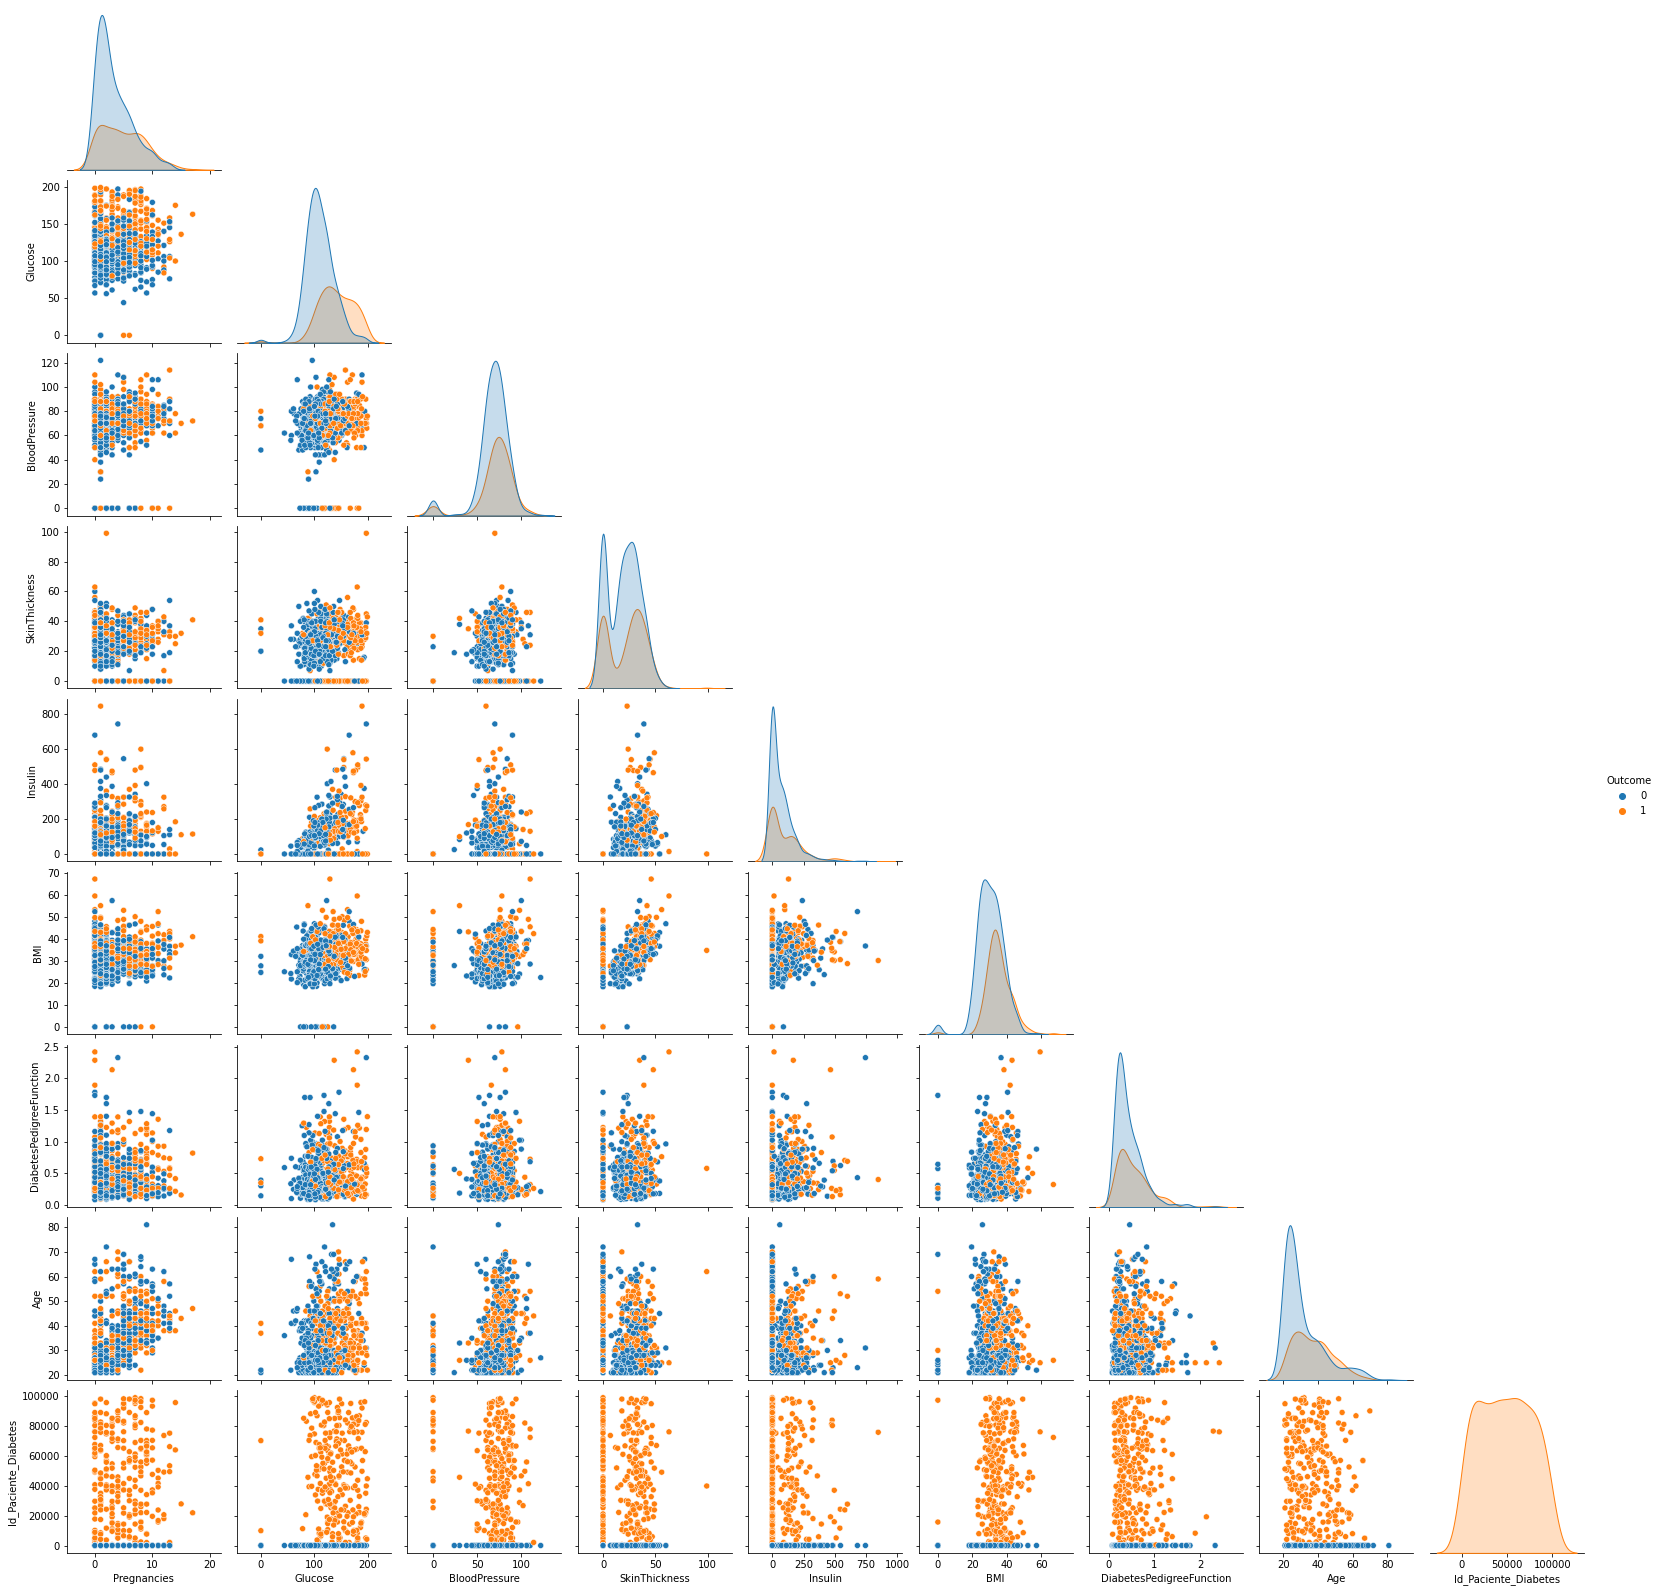

In [52]:
# Veja como ela separa perfeitamente o Target

import seaborn as sns
sns.pairplot(df,hue = 'Outcome', corner = True )

Por isso a dica geral é sempre olhar que tipo de variável você está alimentando o seu modelo e perguntar a si mesmo: Essa variável vai estar disponível quando o modelo for usado em produção? Se a resposta é não, você tem uma "variável futura" que deve ser removida de sua base de treinamento.